# 导入python包

In [2]:

import scipy.io as sio
import sklearn.preprocessing as prep
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.nn.init as init
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import os
# import torch
# from torch import nn
# import numpy as np
# import matplotlib.pyplot as plt
# # import pytorch_lightning as pl

# import torchvision.transforms as transforms
# from PIL import Image
# import segmentation_models_pytorch as smp

# from pprint import pprint
# from torch.utils.data import DataLoader

# from PIL import Image
# import pandas as pd
# from pathlib import Path
# import cv2

# from sklearn.metrics import confusion_matrix

# 函数定义

In [13]:

# torch.set_default_tensor_type(torch.DoubleTensor)


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


def mapStd(X,X_train,X_valid,X_test):
    preprocessor=prep.StandardScaler().fit(X)
    X = preprocessor.transform(X)
    X_train = preprocessor.transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    X_test = preprocessor.transform(X_test)
    return X,X_train,X_valid,X_test


def mapMinmax(X,X_train,X_valid,X_test):
    preprocessor=prep.MinMaxScaler().fit(X)
    X = 2*preprocessor.transform(X)-1
    X_train = 2*preprocessor.transform(X_train)-1
    X_valid = 2*preprocessor.transform(X_valid)-1
    X_test = 2*preprocessor.transform(X_test)-1
    return X,X_train,X_valid,X_test


def mapMinmax2(X_train,X_valid,X_test):
    scaler_minmax = MinMaxScaler()
    X_train = torch.tensor(scaler_minmax.fit_transform(X_train.reshape(-1, 90*90)))
    X_valid = torch.tensor(scaler_minmax.fit_transform(X_train.reshape(-1, 90*90)))  
    X_test = torch.tensor(scaler_minmax.fit_transform(X_train.reshape(-1, 90*90)))
    return X_train.reshape(-1, 1, 90, 90),X_valid.reshape(-1, 1, 90, 90),X_test.reshape(-1, 1, 90, 90)


def load_data(fold):
    data = sio.loadmat('./Datasets/ALLASD{}_NETFC_SG_Pear.mat'.format(fold+1))
    X = data['net']
    X_train = data['net_train']
    X_valid = data['net_valid']
    X_test = data['net_test']

    Idx = [2, 3, 4, 5, 6, 7, 8, 9]  # 3:Age 4:Sex 5:Handedness 6:FIQ 7:VIQ 8:PIQ 9:EYE Status
    Y = data['phenotype'][:, Idx]
    Y_train = data['phenotype_train'][:, Idx]
    Y_valid = data['phenotype_valid'][:, Idx]
    Y_test = data['phenotype_test'][:, Idx]
    col_idx = [1, 4, 5, 6]  # 3:Age 6:FIQ 7:VIQ 8:PIQ
    Y[:, col_idx], Y_train[:, col_idx], \
    Y_valid[:, col_idx], Y_test[:, col_idx] = mapStd(Y[:, col_idx],
                                                     Y_train[:, col_idx],
                                                     Y_valid[:, col_idx],
                                                     Y_test[:, col_idx])
    col_idx = [2, 3, 7]
    Y[:, col_idx], Y_train[:, col_idx], \
    Y_valid[:, col_idx], Y_test[:, col_idx] = mapMinmax(Y[:, col_idx],
                                                        Y_train[:, col_idx],
                                                        Y_valid[:, col_idx],
                                                        Y_test[:, col_idx])


    Y_train2 = data['phenotype_train'][:, 2]
    Y_valid2 = data['phenotype_valid'][:, 2]
    Y_test2 = data['phenotype_test'][:, 2]

    ln = nn.LayerNorm(normalized_shape=[90, 90], elementwise_affine=False)
    X_train = ln(torch.tensor(X_train)).view(-1, 1, 90, 90).type(torch.FloatTensor)
    X_valid = ln(torch.tensor(X_valid)).view(-1, 1, 90, 90).type(torch.FloatTensor)
    X_test = ln(torch.tensor(X_test)).view(-1, 1, 90, 90).type(torch.FloatTensor)
    Y_train = torch.tensor(Y_train)
    Y_valid = torch.tensor(Y_valid)
    Y_test = torch.tensor(Y_test)
    Y_train2 = torch.tensor(Y_train2)
    Y_valid2 = torch.tensor(Y_valid2)
    Y_test2 = torch.tensor(Y_test2)

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_train2, Y_valid2, Y_test2


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.E2E = nn.Conv2d(1, 32, kernel_size=(90, 1))
        self.E2N = nn.Conv2d(32, 64, kernel_size=(90, 1))
        self.N2G = nn.Conv2d(64, 128, kernel_size=(90, 1))
        self.fc1 = nn.Linear(128, 96)
        self.fc2 = nn.Linear(96, 2)
        self.softmax = nn.Softmax(dim=1)
        self.hash = nn.Linear(96, 24)
        self.reg = nn.Linear(24, 8)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.E2E(x) + self.E2E(x).transpose(3, 2))
        x = self.dropout(x)
        x = F.relu(self.E2N(x).transpose(3, 2)*2)
        x = self.dropout(x)
        x = F.relu(self.N2G(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x0 = self.softmax(self.fc2(x))
        x1 = self.hash(x)
        x2 = self.reg(x1)
        return x0, x1, x2


def comput_similarity(n, label):
    sim = torch.zeros([n, n]).type(torch.FloatTensor)
    for i in range(n):
        for j in range(n):
            if label[i, 0] == label[j, 0]:
                sim[i, j] = 1
            else:
                sim[i, j] = 0
    return sim


def train(train_loader, net, optimizer, loss_func, reg_loss, sim_loss):
    loss_sum = 0.
    train_hashcode = torch.empty(len(train_loader.dataset), 24)
    train_hashcode_y = torch.empty(len(train_loader.dataset))
    net.train()
    for step, (batch_x, batch_y) in enumerate(train_loader):
        if use_cuda:
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        sim = comput_similarity(batch_y.size(0), batch_y)
        if use_cuda:
            sim = sim.cuda()
        optimizer.zero_grad()
        out, out_hash, out_reg = net(batch_x)
        label = batch_y[:, 0].long()
        in_pro = torch.mm(out_hash, out_hash.transpose(1, 0))
        loss_step = 100*loss_func(out, label) + sim_loss(in_pro, sim) + 10*reg_loss(out_reg, batch_y)
        hashcode = torch.div(torch.add(torch.sign(torch.sub(torch.sigmoid(out_hash), 0.5)), 1), 2)
        loss_step.backward(retain_graph=True)
        optimizer.step()
        loss_sum += loss_step.data.item()
        train_hashcode[step * train_loader.batch_size:step * train_loader.batch_size + len(batch_x), :] = hashcode
        train_hashcode_y[step * train_loader.batch_size:step * train_loader.batch_size + len(batch_x)] = batch_y[:, 0]

    loss = loss_sum / len(train_loader)

    return loss, train_hashcode, train_hashcode_y


def infer(loader, net, loss_func, reg_loss, sim_loss):
    loss_sum = 0.
    valid_hashcode = torch.empty(len(loader.dataset), 24)
    valid_hashcode_y = torch.empty(len(loader.dataset))
    net.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            sim = comput_similarity(batch_y.size(0), batch_y)
            if use_cuda:
                sim = sim.cuda()
            out, out_hash, out_reg = net(batch_x)
            label = batch_y[:, 0].long()
            in_pro = torch.mm(out_hash, out_hash.transpose(1, 0))
            loss_step = 100*loss_func(out, label) + sim_loss(in_pro, sim) + 10*reg_loss(out_reg, batch_y)
            hashcode = torch.div(torch.add(torch.sign(torch.sub(torch.sigmoid(out_hash), 0.5)), 1), 2)
            loss_sum += loss_step.data.item()
            valid_hashcode[step * loader.batch_size:step * loader.batch_size + len(batch_x), :] = hashcode
            valid_hashcode_y[step * loader.batch_size:step * loader.batch_size + len(batch_x)] = batch_y[:, 0]

        loss = loss_sum / len(loader)

    return loss, valid_hashcode, valid_hashcode_y


def comput_accuracy(output, target, train_y, y):
    y_ = torch.empty(y.shape[0])
    for i in range(y.shape[0]):
        y1 = output[i, :].type(torch.int)
        hm = y1 ^ target.type(torch.int)  # ^表示异或,也就是相同为0,不同为1
        dist = hm.sum(1)
        min = torch.min(dist)
        pos = []
        for k, x in enumerate(dist):
            if x == min:
                pos.append(k)
        label = []
        for t in range(len(pos)):
            label.append(train_y[pos[t]])
        if label.count(0) > label.count(1):  # >=
            y_[i] = 0
        else:
            y_[i] = 1
    correct_prediction = y.type(torch.int) ^ y_.type(torch.int)
    acc = 1 - sum(correct_prediction) / y.shape[0]
    return acc.item()



# 数据处理pipline

## 加载原始数据

In [14]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_train2, Y_valid2, Y_test2 = load_data(1)
X_train, X_valid, X_test = mapMinmax2(X_train, X_valid, X_test)

In [15]:
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape, Y_train2.shape, Y_valid2.shape, Y_test2.shape

(torch.Size([656, 1, 90, 90]),
 torch.Size([656, 1, 90, 90]),
 torch.Size([656, 1, 90, 90]),
 torch.Size([656, 8]),
 torch.Size([218, 8]),
 torch.Size([222, 8]),
 torch.Size([656]),
 torch.Size([218]),
 torch.Size([222]))

In [6]:
np.unique(X_train,return_counts=True)

(array([0.00000000e+00, 2.17435821e-06, 5.08127228e-06, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([8100,    2,    2, ...,  556, 7386,   32], dtype=int64))

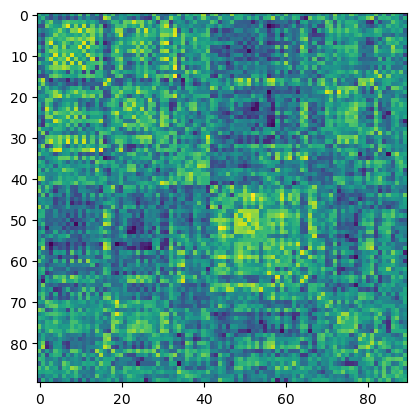

In [16]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    # img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

show_image(X_train[0])

## 构建dataset

In [17]:
train_dataset = TensorDataset(X_train.to(torch.float32), X_train.to(torch.float32))
test_dataset = TensorDataset(X_test.to(torch.float32), X_test.to(torch.float32))

## 构建dataloader

In [18]:

n_cpu = os.cpu_count()
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=n_cpu)
test_dl = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=n_cpu)

## check 输入shape形状

In [20]:
for img,mask in train_dl:
  print(img.shape)
  print(mask.shape)
  # print(img.shape,mask.shape)
  # print(np.unique(mask,return_counts=True))
  break

torch.Size([8, 1, 90, 90])
torch.Size([8, 1, 90, 90])


In [12]:
np.unique(mask,return_counts=True)

(array([0.0000000e+00, 2.1629203e-04, 2.3766493e-03, ..., 9.9867964e-01,
        9.9896574e-01, 1.0000000e+00], dtype=float32),
 array([68,  2,  2, ...,  2,  2, 60], dtype=int64))

torch.Size([1, 90, 90])


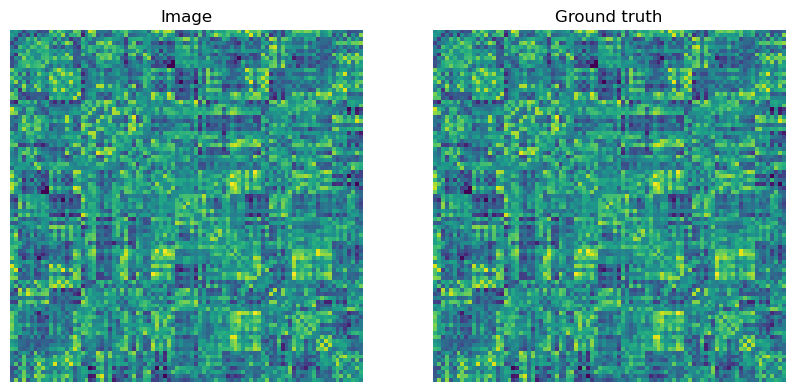

torch.Size([1, 90, 90])


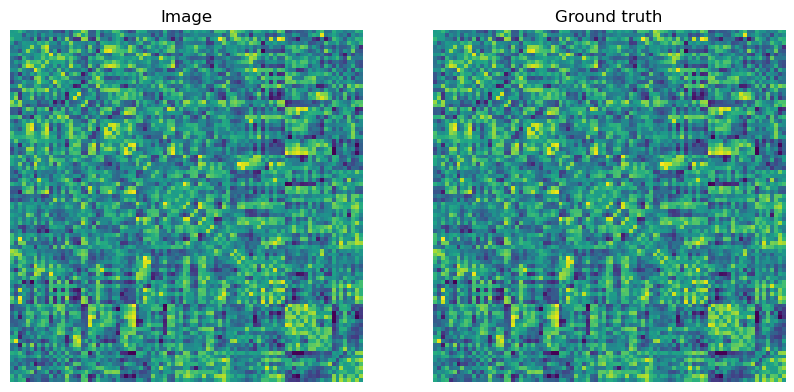

torch.Size([1, 90, 90])


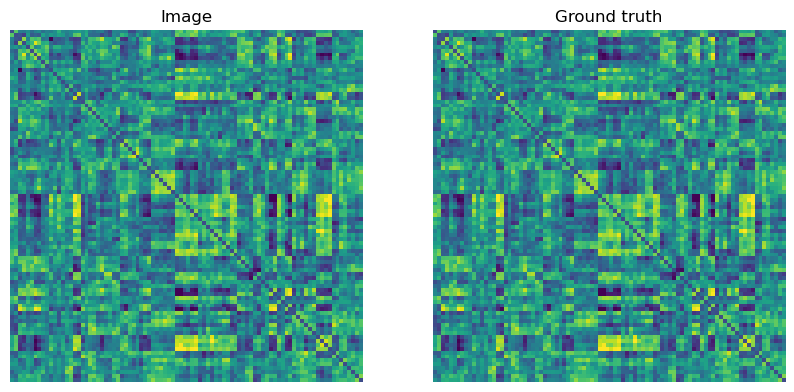

torch.Size([1, 90, 90])


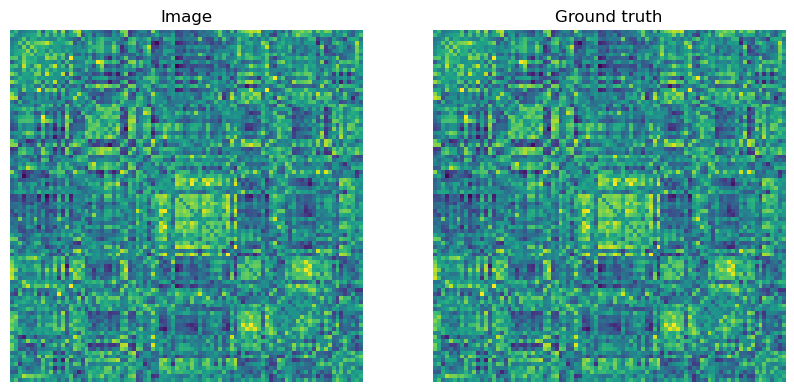

torch.Size([1, 90, 90])


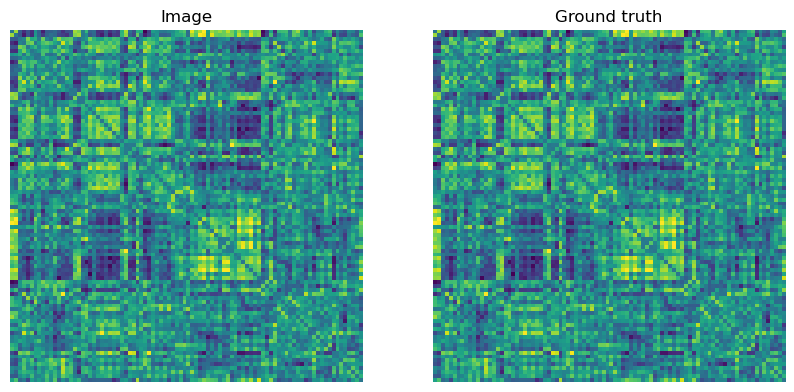

torch.Size([1, 90, 90])


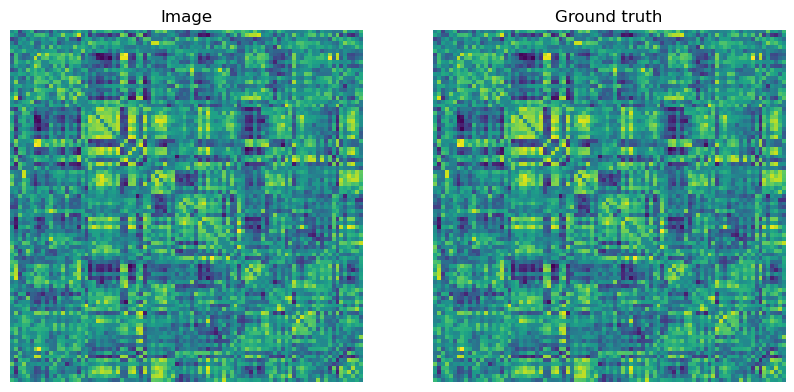

torch.Size([1, 90, 90])


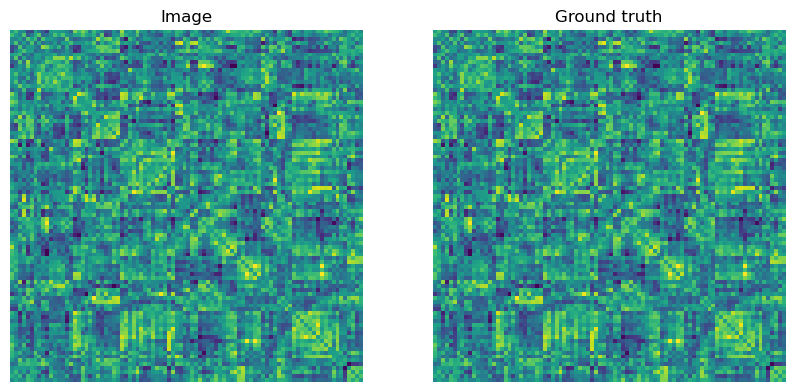

torch.Size([1, 90, 90])


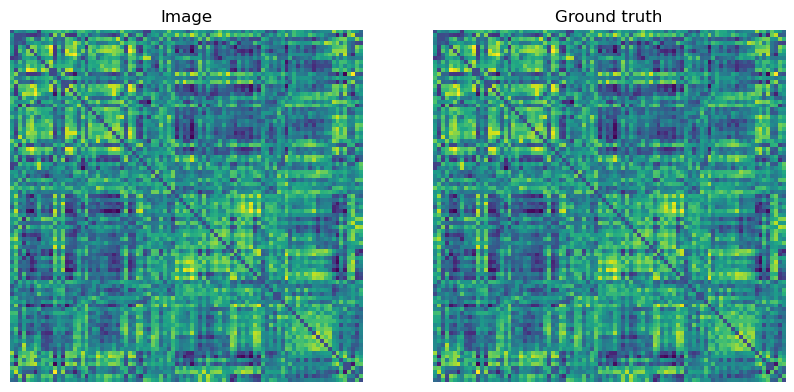

In [23]:
for image, gt_mask in zip(img,mask):
    print(image.shape)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gt_mask.numpy().transpose(1, 2, 0)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.show()

# 确定GPU cpu使用情况

In [24]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# 准备训练和测试循环

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)

            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n , Avg loss: {test_loss:>8f} \n")
    return test_loss

# 自动编码器

## 生成模型

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
model = Autoencoder().to(device)
model(img.to(device)).shape

torch.Size([8, 1, 90, 90])

## 准备损失函数和优化器

In [27]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
print(torch.cuda.is_available())

True


## 训练和评估

In [30]:
epochs = 10
train_loss_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)

    train_loss = test(train_dl, model, loss_fn)
    test_loss = test(test_dl, model, loss_fn)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.029645  [    8/  656]
loss: 0.030360  [   88/  656]
loss: 0.029195  [  168/  656]
loss: 0.028216  [  248/  656]
loss: 0.028406  [  328/  656]
loss: 0.026316  [  408/  656]
loss: 0.026467  [  488/  656]
loss: 0.025940  [  568/  656]
loss: 0.024903  [  648/  656]
Test Error: 
 , Avg loss: 0.026055 

Test Error: 
 , Avg loss: 0.026055 

Epoch 2
-------------------------------
loss: 0.026773  [    8/  656]
loss: 0.024913  [   88/  656]
loss: 0.024475  [  168/  656]
loss: 0.024331  [  248/  656]
loss: 0.027525  [  328/  656]
loss: 0.025825  [  408/  656]
loss: 0.024400  [  488/  656]
loss: 0.025330  [  568/  656]
loss: 0.024640  [  648/  656]
Test Error: 
 , Avg loss: 0.024601 

Test Error: 
 , Avg loss: 0.024601 

Epoch 3
-------------------------------
loss: 0.024728  [    8/  656]
loss: 0.023853  [   88/  656]
loss: 0.024554  [  168/  656]
loss: 0.023374  [  248/  656]
loss: 0.026239  [  328/  656]
loss: 0.024656  [  408/  656]
loss: 0.0237

KeyboardInterrupt: 

## 训练过程可视化

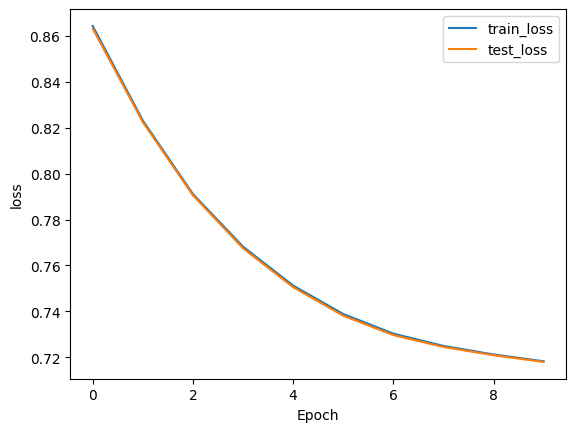

In [20]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')


## 结果可视化

In [21]:
b_img,b_mask = next(iter(test_dl))
b_img,b_mask = next(iter(train_dl))
with torch.no_grad():
    model.eval()
    logits = model(b_img.to(device))
# pr_masks = logits.sigmoid()
predictions = torch.argmax(logits, dim=1)  # 获取预测的类别标签图像
predictions.shape

torch.Size([8, 90, 90])

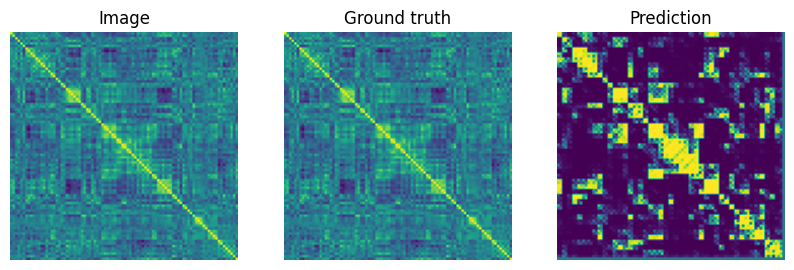

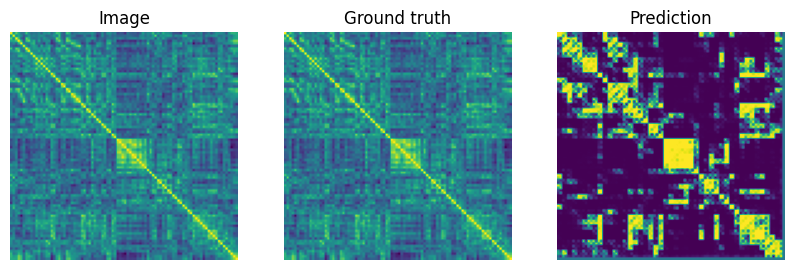

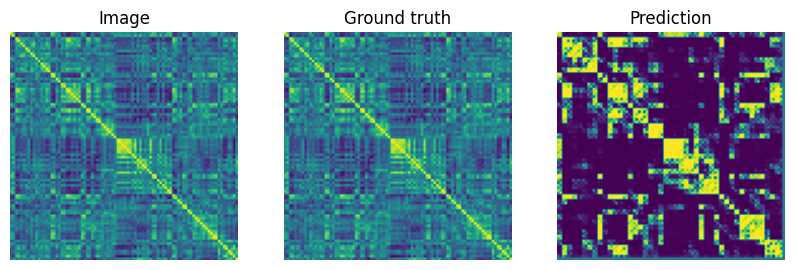

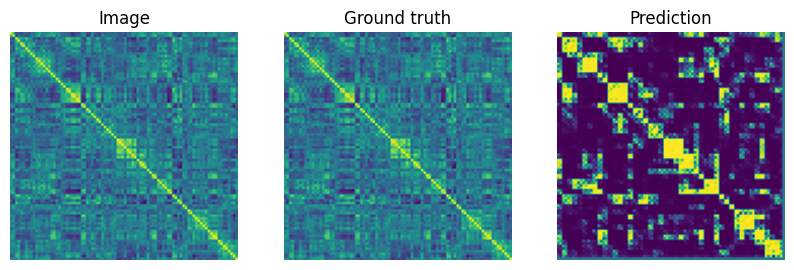

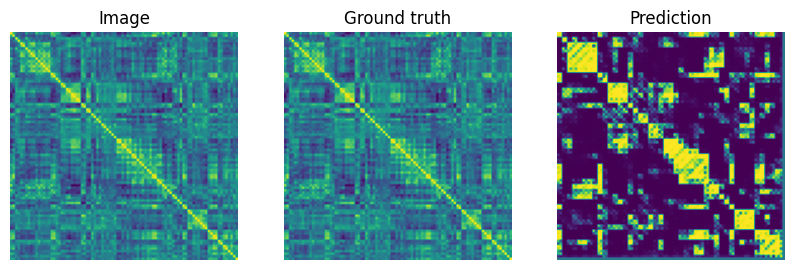

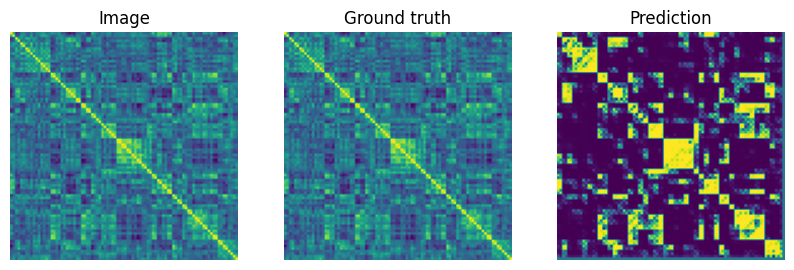

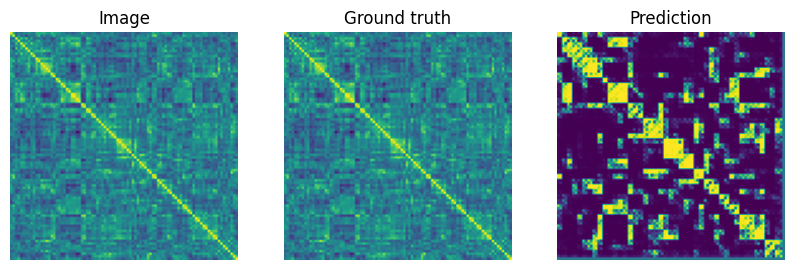

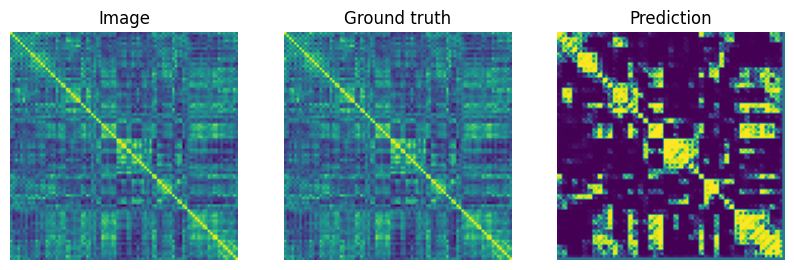

In [22]:


for image, gt_mask, pr_mask in zip(b_img,b_mask, logits):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().transpose(1, 2, 0)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().transpose(1, 2, 0)) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()